In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import model as md
import dataset
import segmentation_models as sm
import tensorflow_addons as tfa

Segmentation Models: using `keras` framework.


In [2]:
labels=pd.read_csv(r'../Data' + r'/labels.csv')
images = os.listdir(r'../Data' + r'/png_images/IMAGES')
masks = os.listdir(r'../Data' + r'/png_masks/MASKS')

df=pd.DataFrame({'images':images,'masks':masks})
df.images=r'../Data/png_images/IMAGES/'+df.images
df.masks=r'../Data/png_masks/MASKS/'+df.masks
train,test=train_test_split(df,test_size=.05,random_state=42)
train,valid=train_test_split(train,test_size=.05,random_state=42)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)

In [3]:
weights = [0.0169491525423729]*59
dice_loss= sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss= dice_loss+(1*focal_loss)

model=md.build_unet((128,128,3),59)
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=3e-3 ),loss=total_loss, metrics=[sm.metrics.IOUScore()])

<h2>Prepare Dataset</h2>

In [4]:
train_ds=dataset.dataset(train.images,train.masks)
test_ds=dataset.dataset(test.images,test.masks)
valid_ds=dataset.dataset(valid.images,valid.masks)

In [5]:
def get_predicted_mask(image):
    prediction=model.predict(image)
    prediction=np.argmax(prediction,axis=-1)
    return prediction

def show_plots(data):
    _, ax = plt.subplots(3,3 , figsize=(16,16))
    for image,mask in data.take(1):

        for i in range(3):
            plt.subplot(3,3,i+1)
            img = image[i]
            Tmsk = np.argmax(mask[i],axis=-1)
            Pmsk = get_predicted_mask(image)

            ax[i, 0].imshow(img, cmap="gray")
            ax[i, 0].set_title('Image')
            ax[i, 0].axis("off")

            ax[i, 1].imshow(Tmsk, cmap="gray")
            ax[i, 1].set_title('Image')
            ax[i, 1].axis("off")

            ax[i, 2].imshow(Pmsk[i], cmap="gray")
            ax[i, 2].set_title('Image')
            ax[i, 2].axis("off")

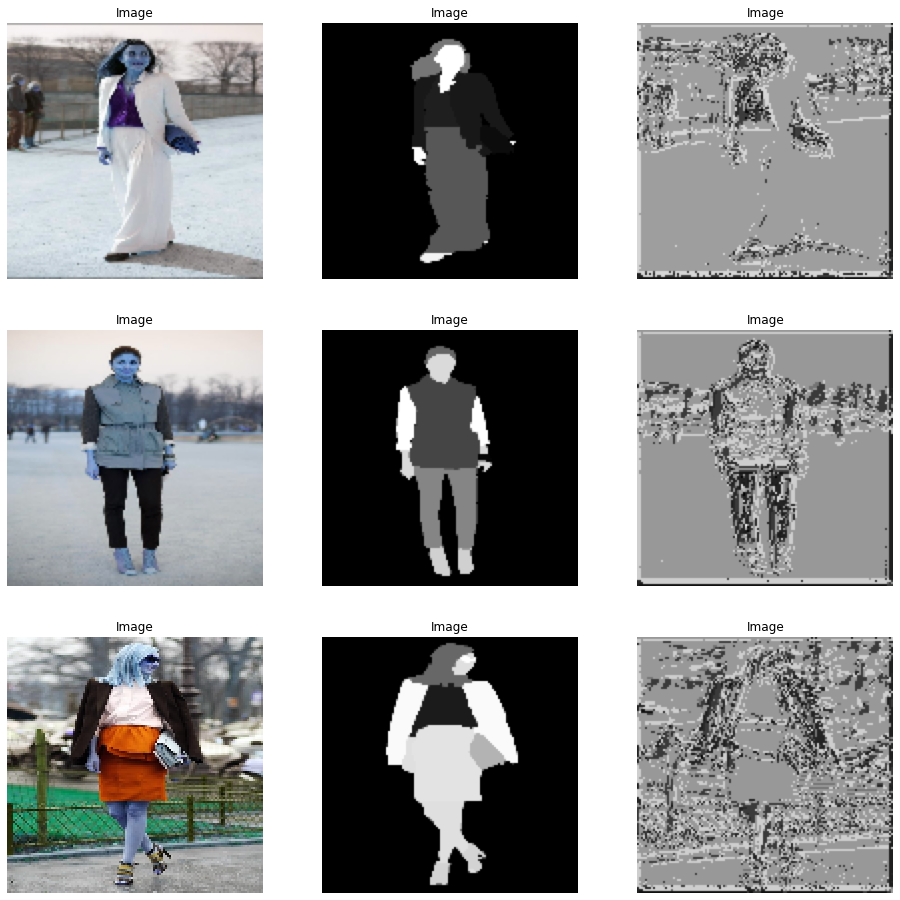

In [6]:
show_plots(train_ds)

In [7]:
tb_callback=tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)
model.fit(train_ds,validation_data=valid_ds,epochs=100 ,callbacks=[tb_callback])

Epoch 1/100
57/57 [==============================] - 23s 269ms/step - loss: 1.0168 - iou_score: 0.0026 - val_loss: 1.0153 - val_iou_score: 0.0026
Epoch 2/100
57/57 [==============================] - 11s 198ms/step - loss: 1.0139 - iou_score: 0.0037 - val_loss: 1.0151 - val_iou_score: 0.0027
Epoch 3/100
57/57 [==============================] - 12s 203ms/step - loss: 1.0103 - iou_score: 0.0057 - val_loss: 1.0082 - val_iou_score: 0.0047
Epoch 4/100
57/57 [==============================] - 11s 202ms/step - loss: 1.0070 - iou_score: 0.0093 - val_loss: 1.0055 - val_iou_score: 0.0076
Epoch 5/100
57/57 [==============================] - 11s 201ms/step - loss: 1.0050 - iou_score: 0.0134 - val_loss: 1.0049 - val_iou_score: 0.0104
Epoch 6/100
57/57 [==============================] - 11s 199ms/step - loss: 1.0040 - iou_score: 0.0170 - val_loss: 1.0050 - val_iou_score: 0.0121
Epoch 7/100
57/57 [==============================] - 11s 200ms/step - loss: 1.0034 - iou_score: 0.0198 - val_loss: 1.0055 - 

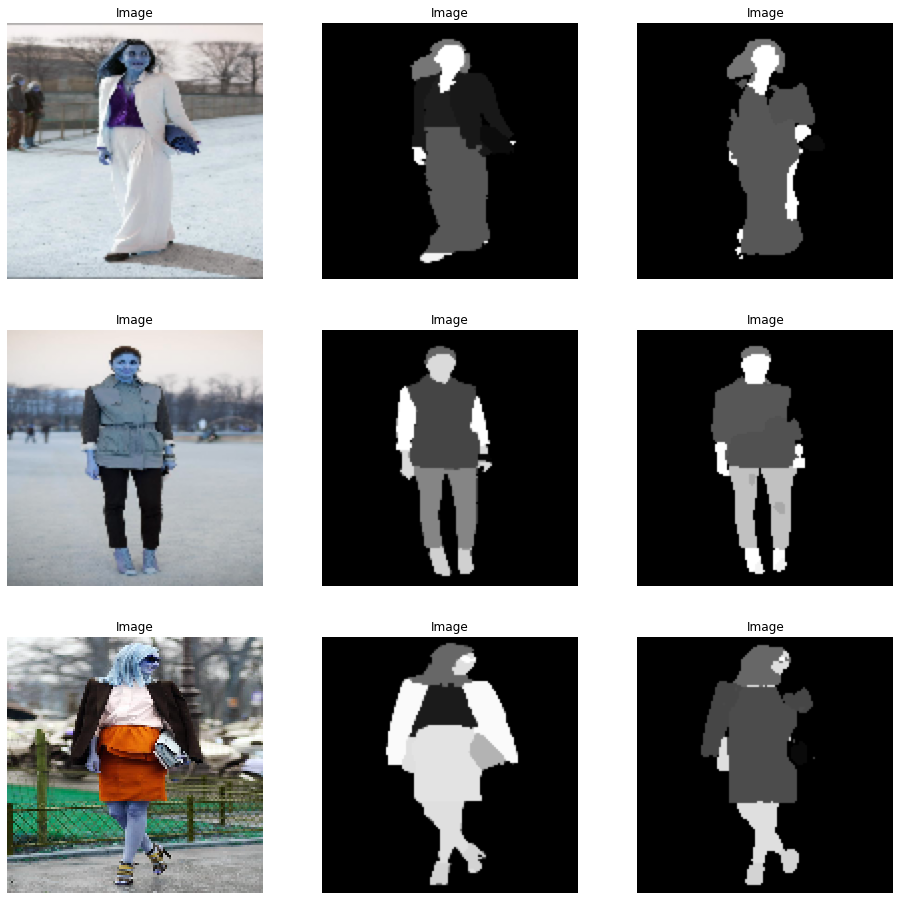

In [10]:
show_plots(test_ds)

In [13]:
model.evaluate(test_ds)

4/4 [==============================] - 1s 226ms/step - loss: 1.0010 - iou_score: 0.0724


[1.0009845495224, 0.07239371538162231]

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             